In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install py3Dmol

Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4891.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4934.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4977.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5020.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5063.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5188.
  warnings.warn(
/opt

Modularity of the graph: 0.9703


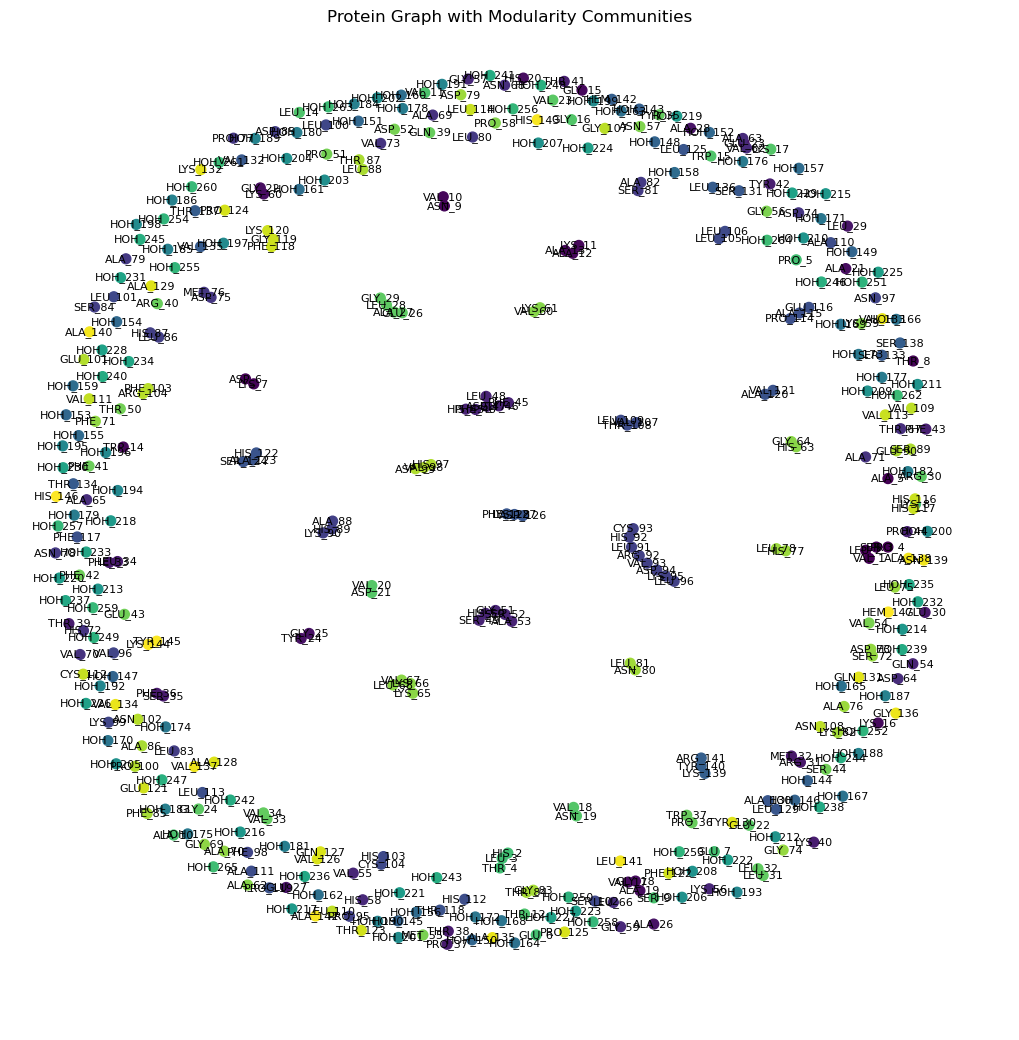

In [24]:
import warnings
from Bio.PDB import PDBParser
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# Suppress PDBConstructionWarnings related to discontinuous chains
warnings.filterwarnings("ignore", category=UserWarning, module="Bio.PDB")

# File path to your PDB file
file_path = '/Users/maitreyasameerganu/Desktop/1a3n.pdb'

# Check if the file exists
if os.path.exists(file_path):
    # Initialize the PDB parser
    parser = PDBParser()
    
    # Parse the structure from the PDB file
    structure = parser.get_structure("Hemoglobin", file_path)
    
    # Create an empty graph
    G = nx.Graph()

    # Iterate through chains and residues
    for model in structure:
        for chain in model:
            # Add nodes for each residue (you can also use atom-level granularity if needed)
            for residue in chain:
                res_name = residue.get_resname()
                res_id = residue.get_id()[1]  # Use residue sequence number as unique ID
                G.add_node(f"{res_name}_{res_id}")

    # Add edges based on proximity (we'll use a simple distance threshold)
    for model in structure:
        for chain in model:
            residues = list(chain)
            for i in range(len(residues)):
                for j in range(i + 1, len(residues)):
                    res_i = residues[i]
                    res_j = residues[j]
                    # Calculate the distance between C-alpha atoms
                    atom_i = res_i['CA'] if 'CA' in res_i else None
                    atom_j = res_j['CA'] if 'CA' in res_j else None
                    if atom_i and atom_j:
                        distance = np.linalg.norm(atom_i.coord - atom_j.coord)
                        # Add an edge if the distance is below a certain threshold
                        if distance < 3.8:  # You can adjust this threshold
                            G.add_edge(f"{res_i.get_resname()}_{res_i.get_id()[1]}",
                                       f"{res_j.get_resname()}_{res_j.get_id()[1]}")

    # Check if the graph is empty or has isolated nodes
    if len(G.nodes) == 0 or len(G.edges) == 0:
        print("The graph has no nodes or edges. Please check the PDB file and ensure it has valid structure data.")
    else:
        # Apply Louvain method for modularity analysis
        communities = list(louvain_communities(G))

        # Calculate modularity
        modularity = nx.algorithms.community.modularity(G, communities)
        print(f"Modularity of the graph: {modularity:.4f}")

        # Visualize the graph with modularity-based color coding
        pos = nx.spring_layout(G)
        community_map = {}
        for idx, community in enumerate(communities):
            for node in community:
                community_map[node] = idx

        # Draw the graph
        plt.figure(figsize=(10, 10))
        nx.draw(G, pos, with_labels=True, node_size=50, font_size=8, node_color=[community_map[node] for node in G.nodes])
        plt.title("Protein Graph with Modularity Communities")
        plt.show()

else:
    print("File not found. Please check the file path.")


In [1]:
import warnings
from Bio.PDB import PDBParser
import os
import networkx as nx
import numpy as np
import py3Dmol
from networkx.algorithms.community import louvain_communities

# Suppress PDBConstructionWarnings related to discontinuous chains
warnings.filterwarnings("ignore", category=UserWarning, module="Bio.PDB")

# File path to your PDB file
file_path = '/Users/maitreyasameerganu/Desktop/1a3n.pdb'

# Check if the file exists
if os.path.exists(file_path):
    # Initialize the PDB parser
    parser = PDBParser()
    
    # Parse the structure from the PDB file
    structure = parser.get_structure("Hemoglobin", file_path)
    
    # Create an empty graph
    G = nx.Graph()

    # Add nodes and edges to the graph based on the protein structure
    for model in structure:
        for chain in model:
            residues = list(chain)
            for i, res_i in enumerate(residues):
                res_name = res_i.get_resname()
                res_id = res_i.get_id()[1]  # Unique residue ID
                G.add_node(f"{res_name}_{res_id}")

                for j, res_j in enumerate(residues):
                    if i < j:
                        # Calculate the distance between C-alpha atoms (for proximity-based edges)
                        atom_i = res_i['CA'] if 'CA' in res_i else None
                        atom_j = res_j['CA'] if 'CA' in res_j else None
                        if atom_i and atom_j:
                            distance = np.linalg.norm(atom_i.coord - atom_j.coord)
                            if distance < 3.8:  # Distance threshold for edges
                                G.add_edge(f"{res_name}_{res_id}", f"{res_j.get_resname()}_{res_j.get_id()[1]}")

    # Check if the graph has nodes and edges
    if len(G.nodes) == 0 or len(G.edges) == 0:
        print("The graph has no nodes or edges. Please check the PDB file.")
    else:
        # Apply Louvain method for modularity analysis to detect clusters (communities)
        communities = list(louvain_communities(G))

        # Calculate modularity
        modularity = nx.algorithms.community.modularity(G, communities)
        print(f"Modularity of the graph: {modularity:.4f}")

        # Color the communities (clusters)
        community_map = {}
        colors = ['#FF0000', '#0000FF', '#FF00FF', '#00FFFF']  # Colors for different communities
        for idx, community in enumerate(communities):
            color = colors[idx % len(colors)]  # Assign color to community
            for node in community:
                community_map[node] = color

        # Create a 3D visualization of the protein structure using py3Dmol
        viewer = py3Dmol.view(width=800, height=600)

        # Add the structure to the 3D viewer
        with open(file_path, 'r') as pdb_file:
            viewer.addModel(pdb_file.read(), "pdb")

        # Map residues to their community colors and visualize the 3D structure
        for node, color in community_map.items():
            res_name, res_id = node.split("_")
            for model in structure:
                for chain in model:
                    for residue in chain:
                        if residue.get_resname() == res_name and residue.get_id()[1] == int(res_id):
                            # Set the residue style with thicker lines and community colors
                            viewer.setStyle(
                                {'model': -1, 'residue': int(res_id)}, 
                                {'stick': {'colorscheme': color, 'radius': 0.3}}  # Adjust radius for thickness
                            )

        # Zoom to fit the structure
        viewer.zoomTo()
        viewer.show()

else:
    print("File not found. Please check the file path.")


/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4891.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4934.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4977.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5020.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5063.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5188.
  warnings.warn(
/opt

Modularity of the graph: 0.9703


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4891.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4934.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4977.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5020.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5063.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5188.
  warnings.warn(
/opt

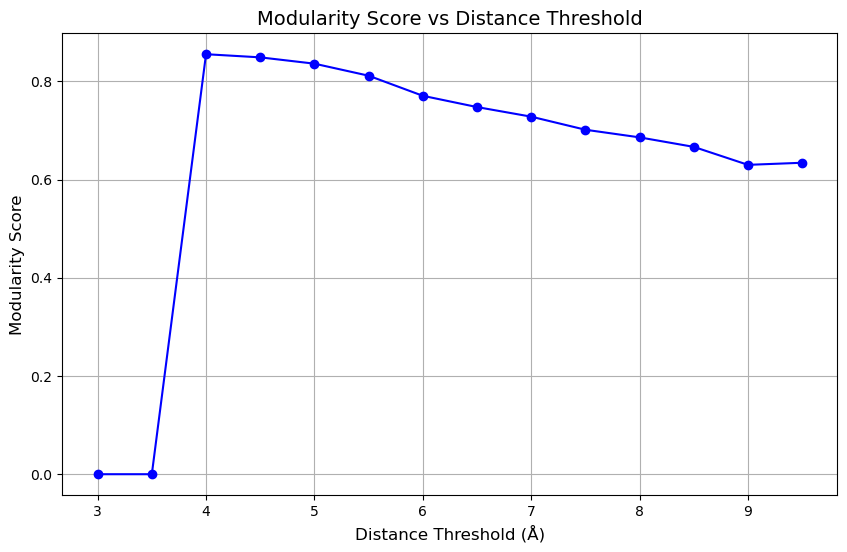

In [1]:
import warnings
from Bio.PDB import PDBParser
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# Suppress PDBConstructionWarnings related to discontinuous chains
warnings.filterwarnings("ignore", category=UserWarning, module="Bio.PDB")

# File path to your PDB file
file_path = '/Users/maitreyasameerganu/Desktop/1a3n.pdb'

# Check if the file exists
if os.path.exists(file_path):
    # Initialize the PDB parser
    parser = PDBParser()
    
    # Parse the structure from the PDB file
    structure = parser.get_structure("Hemoglobin", file_path)
    
    # Create a function to calculate modularity for a given distance threshold
    def calculate_modularity(threshold):
        G = nx.Graph()

        # Add nodes and edges to the graph based on the protein structure
        for model in structure:
            for chain in model:
                residues = list(chain)
                for i, res_i in enumerate(residues):
                    res_name = res_i.get_resname()
                    res_id = res_i.get_id()[1]  # Unique residue ID
                    G.add_node(f"{res_name}_{res_id}")

                    for j, res_j in enumerate(residues):
                        if i < j:
                            # Calculate the distance between C-alpha atoms
                            atom_i = res_i['CA'] if 'CA' in res_i else None
                            atom_j = res_j['CA'] if 'CA' in res_j else None
                            if atom_i and atom_j:
                                distance = np.linalg.norm(atom_i.coord - atom_j.coord)
                                if distance < threshold:  # Use threshold for edges
                                    G.add_edge(f"{res_name}_{res_id}",
                                               f"{res_j.get_resname()}_{res_j.get_id()[1]}")
        
        # If graph has no nodes or edges, skip modularity calculation
        if len(G.nodes) == 0 or len(G.edges) == 0:
            return None
        
        # Apply Louvain method for modularity analysis to detect clusters
        communities = list(louvain_communities(G))

        # Calculate modularity
        return nx.algorithms.community.modularity(G, communities)

    # Define distance thresholds to test
    distance_thresholds = np.arange(3.0, 10.0, 0.5)  # Thresholds from 3.0 Å to 10.0 Å
    modularity_scores = []

    # Calculate modularity for each threshold
    for threshold in distance_thresholds:
        modularity = calculate_modularity(threshold)
        if modularity is not None:
            modularity_scores.append(modularity)
        else:
            modularity_scores.append(0)  # Add 0 for cases where the graph is empty

    # Plot the modularity scores against the distance thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(distance_thresholds, modularity_scores, marker='o', color='b')
    plt.title('Modularity Score vs Distance Threshold', fontsize=14)
    plt.xlabel('Distance Threshold (Å)', fontsize=12)
    plt.ylabel('Modularity Score', fontsize=12)
    plt.grid(True)
    plt.show()

else:
    print("File not found. Please check the file path.")


The highest modularity score is 0.8750 at a distance threshold of 3.50 Å.


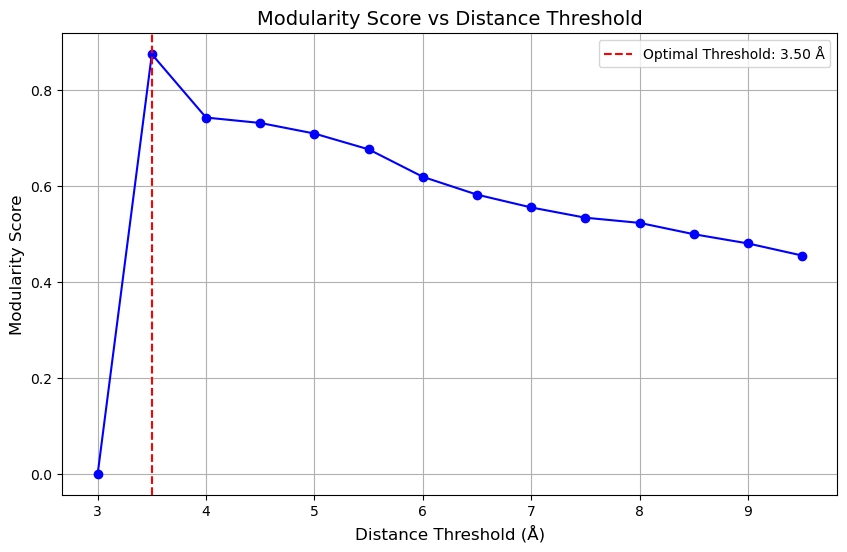

In [8]:
import warnings
from Bio.PDB import PDBParser
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# Suppress PDBConstructionWarnings related to discontinuous chains
warnings.filterwarnings("ignore", category=UserWarning, module="Bio.PDB")

# File path to your PDB file
file_path = '/Users/maitreyasameerganu/Desktop/1bpv.pdb'

# Check if the file exists
if os.path.exists(file_path):
    # Initialize the PDB parser
    parser = PDBParser()
    
    # Parse the structure from the PDB file
    structure = parser.get_structure("titin", file_path)
    
    # Create a function to calculate modularity for a given distance threshold
    def calculate_modularity(threshold):
        G = nx.Graph()

        # Add nodes and edges to the graph based on the protein structure
        for model in structure:
            for chain in model:
                residues = list(chain)
                for i, res_i in enumerate(residues):
                    res_name = res_i.get_resname()
                    res_id = res_i.get_id()[1]  # Unique residue ID
                    G.add_node(f"{res_name}_{res_id}")

                    for j, res_j in enumerate(residues):
                        if i < j:
                            # Calculate the distance between C-alpha atoms
                            atom_i = res_i['CA'] if 'CA' in res_i else None
                            atom_j = res_j['CA'] if 'CA' in res_j else None
                            if atom_i and atom_j:
                                distance = np.linalg.norm(atom_i.coord - atom_j.coord)
                                if distance < threshold:  # Use threshold for edges
                                    G.add_edge(f"{res_name}_{res_id}",
                                               f"{res_j.get_resname()}_{res_j.get_id()[1]}")
        
        # If graph has no nodes or edges, skip modularity calculation
        if len(G.nodes) == 0 or len(G.edges) == 0:
            return None
        
        # Apply Louvain method for modularity analysis to detect clusters
        communities = list(louvain_communities(G))

        # Calculate modularity
        return nx.algorithms.community.modularity(G, communities)

    # Define distance thresholds to test
    distance_thresholds = np.arange(3.0, 10.0, 0.5)  # Thresholds from 3.0 Å to 10.0 Å
    modularity_scores = []

    # Calculate modularity for each threshold
    for threshold in distance_thresholds:
        modularity = calculate_modularity(threshold)
        if modularity is not None:
            modularity_scores.append(modularity)
        else:
            modularity_scores.append(0)  # Add 0 for cases where the graph is empty

    # Find the maximum modularity and corresponding threshold
    max_modularity = max(modularity_scores)
    optimal_threshold = distance_thresholds[np.argmax(modularity_scores)]

    print(f"The highest modularity score is {max_modularity:.4f} at a distance threshold of {optimal_threshold:.2f} Å.")

    # Plot the modularity scores against the distance thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(distance_thresholds, modularity_scores, marker='o', color='b')
    plt.title('Modularity Score vs Distance Threshold', fontsize=14)
    plt.xlabel('Distance Threshold (Å)', fontsize=12)
    plt.ylabel('Modularity Score', fontsize=12)
    plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f} Å')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("File not found. Please check the file path.")


In [20]:
import warnings
from Bio.PDB import PDBParser
import os
import networkx as nx
import numpy as np
import py3Dmol
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# Suppress PDBConstructionWarnings related to discontinuous chains
warnings.filterwarnings("ignore", category=UserWarning, module="Bio.PDB")

# File path to your PDB file
file_path = '/Users/maitreyasameerganu/Desktop/1a3n.pdb'

# Check if the file exists
if os.path.exists(file_path):
    # Initialize the PDB parser
    parser = PDBParser()
    
    # Parse the structure from the PDB file
    structure = parser.get_structure("Haemoglobin", file_path)
    
    # Create an empty graph
    G = nx.Graph()

    # Add nodes and edges to the graph based on the protein structure
    for model in structure:
        for chain in model:
            residues = list(chain)
            for i, res_i in enumerate(residues):
                res_name = res_i.get_resname()
                res_id = res_i.get_id()[1]  # Unique residue ID
                G.add_node(f"{res_name}_{res_id}")

                for j, res_j in enumerate(residues):
                    if i < j:
                        # Calculate the distance between C-alpha atoms
                        atom_i = res_i['CA'] if 'CA' in res_i else None
                        atom_j = res_j['CA'] if 'CA' in res_j else None
                        if atom_i and atom_j:
                            distance = np.linalg.norm(atom_i.coord - atom_j.coord)
                            if distance < 3.8:  # Distance threshold for edges
                                G.add_edge(f"{res_name}_{res_id}",
                                           f"{res_j.get_resname()}_{res_j.get_id()[1]}")

    # Check if the graph has nodes and edges
    if len(G.nodes) == 0 or len(G.edges) == 0:
        print("The graph has no nodes or edges. Please check the PDB file.")
    else:
        # Apply Louvain method for modularity analysis
        communities = list(louvain_communities(G))

        # Calculate modularity
        modularity = nx.algorithms.community.modularity(G, communities)
        print(f"Modularity of the graph: {modularity:.4f}")

        # Assign colors to communities alternately using red and blue
        fixed_colors = ['rgb(255,0,0)', 'rgb(0,0,255)']  # Red and Blue
        community_map = {}
        for idx, community in enumerate(communities):
            color = fixed_colors[idx % 2]  # Alternate between red and blue
            for node in community:
                community_map[node] = color

        # Create a 3D visualization of the protein structure using py3Dmol
        viewer = py3Dmol.view(width=800, height=600)

        # Add the structure to the 3D viewer
        with open(file_path, 'r') as pdb_file:
            viewer.addModel(pdb_file.read(), "pdb")

        # Map residues to their community colors and visualize the 3D structure
        for node, color in community_map.items():
            res_name, res_id = node.split("_")
            viewer.setStyle(
                {'resn': res_name, 'resi': int(res_id)},
                {'stick': {'color': color}}
            )

        # Zoom to fit the structure
        viewer.zoomTo()
        viewer.show()

else:
    print("File not found. Please check the file path.")


/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 4891.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4934.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 4977.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5020.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5063.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5188.
  warnings.warn(
/opt

Modularity of the graph: 0.9703


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [14]:
import warnings
from Bio.PDB import PDBParser
import py3Dmol
import os

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="Bio.PDB")

# File path to your PDB file
file_path = '/Users/maitreyasameerganu/Desktop/1a3n.pdb'

# Check if the file exists
if os.path.exists(file_path):
    # Create a 3D viewer
    viewer = py3Dmol.view(width=800, height=600)

    # Add the structure to the viewer
    with open(file_path, 'r') as pdb_file:
        viewer.addModel(pdb_file.read(), "pdb")
    
    # Define chains for red and blue clusters
    red_clusters = ['A', 'C']  # Assign two chains to red
    blue_clusters = ['B', 'D']  # Assign two chains to blue

    # Color red clusters
    for chain in red_clusters:
        viewer.setStyle({'chain': chain}, {'cartoon': {'color': 'red'}})
    
    # Color blue clusters
    for chain in blue_clusters:
        viewer.setStyle({'chain': chain}, {'cartoon': {'color': 'blue'}})

    # Adjust the zoom for the structure
    viewer.zoomTo()

    # Show the 3D viewer
    viewer.show()

else:
    print("File not found. Please check the file path.")


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [36]:
import warnings
from Bio.PDB import PDBParser
import os
import networkx as nx
import numpy as np
import py3Dmol
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# Suppress PDBConstructionWarnings related to discontinuous chains
warnings.filterwarnings("ignore", category=UserWarning, module="Bio.PDB")

# File path to your PDB file
file_path = '/Users/maitreyasameerganu/Desktop/1mbn.pdb'

# Check if the file exists
if os.path.exists(file_path):
    # Initialize the PDB parser
    parser = PDBParser()
    
    # Parse the structure from the PDB file
    structure = parser.get_structure("myoglobin", file_path)
    
    # Create an empty graph
    G = nx.Graph()

    # Add nodes and edges to the graph based on the protein structure
    for model in structure:
        for chain in model:
            residues = list(chain)
            for i, res_i in enumerate(residues):
                res_name = res_i.get_resname()
                res_id = res_i.get_id()[1]  # Unique residue ID
                G.add_node(f"{res_name}_{res_id}")

                for j, res_j in enumerate(residues):
                    if i < j:
                        # Calculate the distance between C-alpha atoms
                        atom_i = res_i['CA'] if 'CA' in res_i else None
                        atom_j = res_j['CA'] if 'CA' in res_j else None
                        if atom_i and atom_j:
                            distance = np.linalg.norm(atom_i.coord - atom_j.coord)
                            if distance < 3.8:  # Distance threshold for edges
                                G.add_edge(f"{res_name}_{res_id}",
                                           f"{res_j.get_resname()}_{res_j.get_id()[1]}")

    # Check if the graph has nodes and edges
    if len(G.nodes) == 0 or len(G.edges) == 0:
        print("The graph has no nodes or edges. Please check the PDB file.")
    else:
        # Apply Louvain method for modularity analysis
        communities = list(louvain_communities(G))

        # Calculate modularity
        modularity = nx.algorithms.community.modularity(G, communities)
        print(f"Modularity of the graph: {modularity:.4f}")
        print(f"Number of communities: {len(communities)}")

        # Generate a color palette based on the number of communities
        cmap = plt.cm.get_cmap("viridis", len(communities))
        community_map = {}
        for idx, community in enumerate(communities):
            color = cmap(idx)  # Assign unique color to each community
            hex_color = f"rgb({int(color[0]*255)},{int(color[1]*255)},{int(color[2]*255)})"
            for node in community:
                community_map[node] = hex_color

        # Create a 3D visualization of the protein structure using py3Dmol
        viewer = py3Dmol.view(width=800, height=600)

        # Add the structure to the 3D viewer
        with open(file_path, 'r') as pdb_file:
            viewer.addModel(pdb_file.read(), "pdb")

        # Map residues to their community colors and visualize the 3D structure
        for node, color in community_map.items():
            res_name, res_id = node.split("_")
            viewer.setStyle(
                {'resn': res_name, 'resi': int(res_id)},
                {'stick': {'colorscheme': {'prop': 'color', 'value': color}}}
            )

        # Zoom to fit the structure
        viewer.zoomTo()
        viewer.show()

else:
    print("File not found. Please check the file path.")


Modularity of the graph: 0.9704
Number of communities: 88


/var/folders/84/x0zysmm9265283q4psw099000000gn/T/ipykernel_1732/2758467205.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", len(communities))


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

The highest modularity score is 0.8481 at a distance threshold of 5.00 Å.


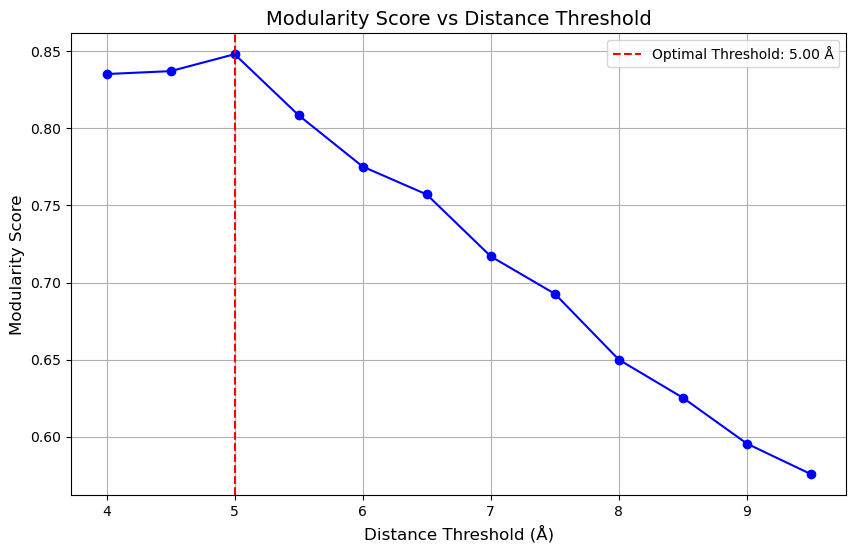

In [34]:
import warnings
from Bio.PDB import PDBParser
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import louvain_communities

# Suppress PDBConstructionWarnings related to discontinuous chains
warnings.filterwarnings("ignore", category=UserWarning, module="Bio.PDB")

# File path to your PDB file
file_path = '/Users/maitreyasameerganu/Desktop/1mbn.pdb'

# Check if the file exists
if os.path.exists(file_path):
    # Initialize the PDB parser
    parser = PDBParser()
    
    # Parse the structure from the PDB file
    structure = parser.get_structure("myoglobin", file_path)
    
    # Create a function to calculate modularity for a given distance threshold
    def calculate_modularity(threshold):
        G = nx.Graph()

        # Add nodes and edges to the graph based on the protein structure
        for model in structure:
            for chain in model:
                residues = list(chain)
                for i, res_i in enumerate(residues):
                    res_name = res_i.get_resname()
                    res_id = res_i.get_id()[1]  # Unique residue ID
                    G.add_node(f"{res_name}_{res_id}")

                    for j, res_j in enumerate(residues):
                        if i < j:
                            # Calculate the distance between C-alpha atoms
                            atom_i = res_i['CA'] if 'CA' in res_i else None
                            atom_j = res_j['CA'] if 'CA' in res_j else None
                            if atom_i and atom_j:
                                distance = np.linalg.norm(atom_i.coord - atom_j.coord)
                                if distance < threshold:  # Use threshold for edges
                                    G.add_edge(f"{res_name}_{res_id}",
                                               f"{res_j.get_resname()}_{res_j.get_id()[1]}")
        
        # If graph has no nodes or edges, skip modularity calculation
        if len(G.nodes) == 0 or len(G.edges) == 0:
            return None
        
        # Apply Louvain method for modularity analysis to detect clusters
        communities = list(louvain_communities(G))

        # Calculate modularity
        return nx.algorithms.community.modularity(G, communities)

    # Define distance thresholds to test
    distance_thresholds = np.arange(3.0, 10.0, 0.5)  # Thresholds from 3.0 Å to 10.0 Å
    modularity_scores = []

    # Calculate modularity for each threshold
    for threshold in distance_thresholds:
        modularity = calculate_modularity(threshold)
        modularity_scores.append(modularity if modularity is not None else None)

    # Filter out None values (or invalid scores) for analysis
    valid_scores = [(t, m) for t, m in zip(distance_thresholds, modularity_scores) if m is not None]

    # Extract thresholds and modularity scores into separate lists
    valid_thresholds, valid_modularities = zip(*valid_scores)

    # Find the maximum modularity and corresponding threshold
    max_modularity = max(valid_modularities)
    optimal_threshold = valid_thresholds[np.argmax(valid_modularities)]

    print(f"The highest modularity score is {max_modularity:.4f} at a distance threshold of {optimal_threshold:.2f} Å.")

    # Plot the modularity scores against the distance thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(valid_thresholds, valid_modularities, marker='o', color='b')
    plt.title('Modularity Score vs Distance Threshold', fontsize=14)
    plt.xlabel('Distance Threshold (Å)', fontsize=12)
    plt.ylabel('Modularity Score', fontsize=12)
    plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f} Å')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("File not found. Please check the file path.")
